# Derive spectral similarities using 'classical' measures (codine, modified cosine)

The code in this notebook is to derive an array of all-vs-all spectral similarity scores for the uniqueInchikey subset (about 11,000 spectra). 

### Import libraries, folder names, and Spec2Vec functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

# Import and filter MS-MS data from MGF file (positive ionization mode)

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
**1. Discard spectra with too few peaks.**  
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

**2. Filter out noise.**  
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  

**3. But keep enough information.**  
Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


### Inspect data

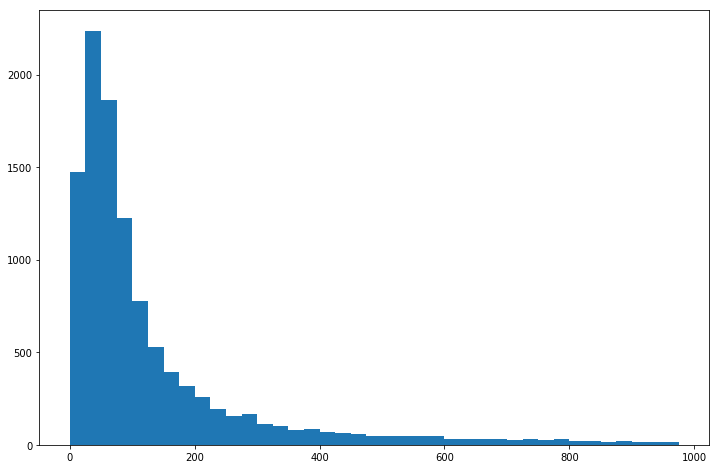

In [4]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,1000,25))

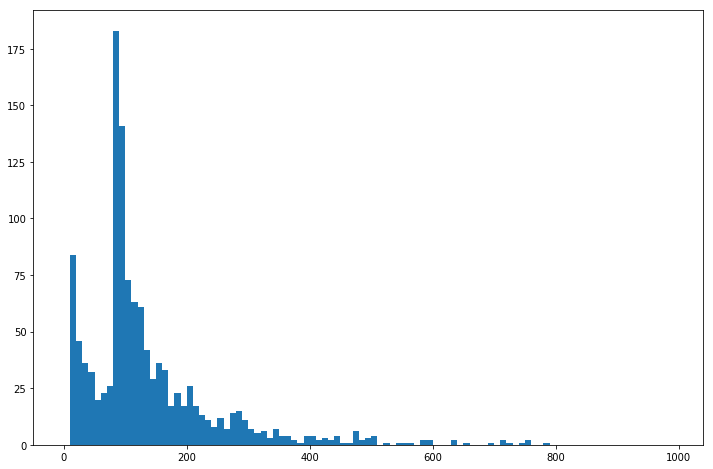

In [5]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1000,10))

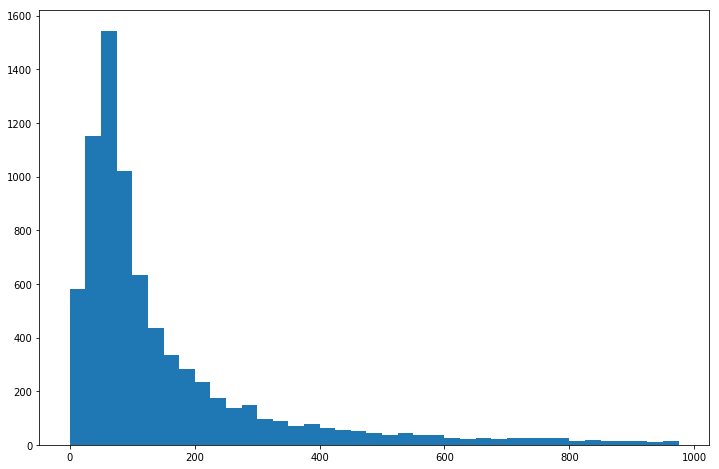

In [6]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 300)], np.arange(0,1000,25))

---
# Calculate cosine scores for all-vs all spectra

The cosine score here has two key parameters: tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the cosine score by matching peaks of two spectra. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [7]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol0005.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [8]:
# show number of matched peaks:
cosine_matches_greedy[:10,:10]

array([[19.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0., 79., 38.,  0.,  0.,  0., 12., 41., 41., 44.],
       [ 0., 38., 88.,  0.,  0.,  0., 12., 36., 39., 22.],
       [ 0.,  0.,  0., 18.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 22.,  0.,  0.,  0.,  0.],
       [ 0., 12., 12.,  0.,  0.,  0., 24., 13., 12.,  9.],
       [ 0., 41., 36.,  0.,  0.,  0., 13., 51., 29., 28.],
       [ 1., 41., 39.,  0.,  0.,  0., 12., 29., 80., 30.],
       [ 0., 44., 22.,  0.,  0.,  0.,  9., 28., 30., 47.]])

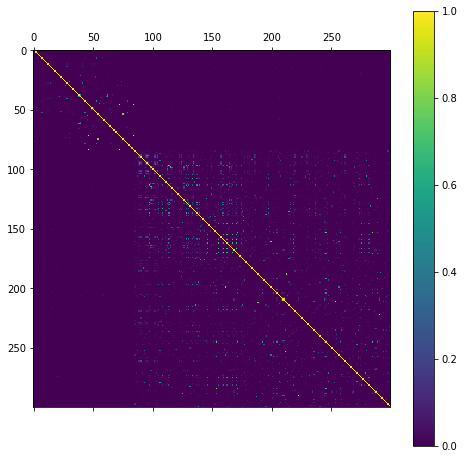

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.matshow(cosine_sim_greedy[200:500,200:500], fignum=0)
plt.colorbar()

---
# Calculate modified cosine scores for all-vs all spectra

Modified cosine score is -among others- used by [GNPS](https://ccms-ucsd.github.io/GNPSDocumentation/massspecbackground/networkingtheory/). It's key parameters are tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the modified cosine score. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [26]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol0005.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [27]:
# show number of matched peaks:
modcos_matches_greedy[:10,:10]

array([[19.,  1.,  0.,  0.,  1.,  3.,  0.,  1.,  1.,  1.],
       [ 1., 79., 38.,  0.,  0.,  2., 13., 42., 41., 44.],
       [ 0., 38., 88.,  0.,  1.,  0., 12., 36., 39., 22.],
       [ 0.,  0.,  0., 18.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0., 12.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  0.,  0.,  0., 22.,  0.,  1.,  0.,  1.],
       [ 0., 13., 12.,  0.,  0.,  0., 24., 14., 12., 10.],
       [ 1., 42., 36.,  0.,  0.,  1., 14., 51., 29., 29.],
       [ 1., 41., 39.,  0.,  0.,  0., 12., 29., 80., 30.],
       [ 1., 44., 22.,  0.,  0.,  1., 10., 29., 30., 47.]])

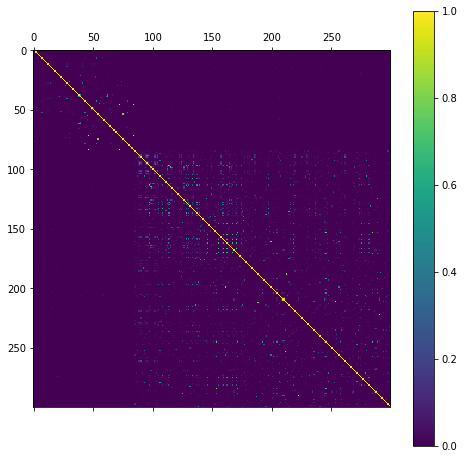

In [29]:
plt.figure(figsize=(8,8))
plt.matshow(cosine_sim_greedy[200:500,200:500], fignum=0)
plt.colorbar()

---
# Compare to reference scores based on molecular fingerprints

In [30]:
from plotting_functions import plot_precentile

### Import reference similarity scores (based on molecular fingerprints)

In [32]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_morgan3_dice2048_191119.npy')
mol_sim_morgan3 = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'dice',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [33]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
mol_sim_rdkit = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'jaccard',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [36]:
np.where(np.sum(mol_sim_rdkit, axis=0) ==0)[0]

array([], dtype=int64)

In [38]:
np.where(np.isnan(mol_sim_rdkit) == True)

(array([], dtype=int64), array([], dtype=int64))

In [47]:
# pass on IDs for which fingerprint could not be calculated:
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

### Compare scores

In [48]:
scores = np.delete(np.delete(modcos_sim_greedy, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = scores.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
scores = np.delete(scores.reshape(length**2), remove_diagonal)

scores_ref = np.delete(np.delete(mol_sim_morgan3, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
scores_ref = np.delete(scores_ref.reshape(length**2), remove_diagonal)

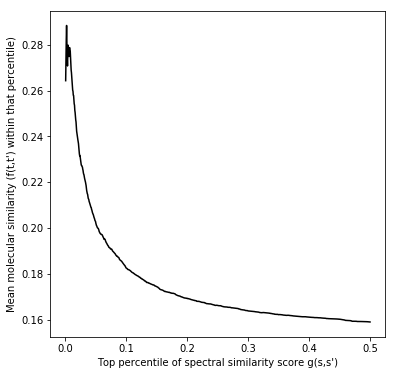

In [49]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(scores, scores_ref, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_modcos_uniqueInchikey_pos_morgan3_2048_dice_200219.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

## Cosine: explore different  min_match settings

In [59]:
num_bins = 1000
show_top_percentile = 0.5

ref_score_cum_collection_cosine = []

length = mol_sim_morgan3.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])
#scores_ref = np.delete(mol_sim.reshape(length**2), remove_diagonal)

N = 19
for i in range(N):
    print("Set min_match to", i, "(round", i, "of", N, ")")
    
    # Select only those scores with > min_match matches:
    M_sim_cosine = cosine_sim_greedy * (cosine_matches_greedy > i)
    M_sim_cosine = np.delete(np.delete(M_sim_cosine, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    scores = np.delete(M_sim_cosine.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    scores_sort = np.sort(scores)
    starting_point = scores_sort[int(scores.shape[0] - scores.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_scores = np.where(scores < starting_point)[0]
    scores_select = np.delete(scores, low_scores)
    scores_ref_select = np.delete(scores_ref, low_scores)

    length_selected = scores_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = scores_select
    Data[1,:] = scores_ref_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection_cosine.append(np.array(ref_score_cum))

Set min_match to 0 (round 0 of 19 )
Set min_match to 1 (round 1 of 19 )
Set min_match to 2 (round 2 of 19 )
Set min_match to 3 (round 3 of 19 )
Set min_match to 4 (round 4 of 19 )
Set min_match to 5 (round 5 of 19 )
Set min_match to 6 (round 6 of 19 )
Set min_match to 7 (round 7 of 19 )
Set min_match to 8 (round 8 of 19 )
Set min_match to 9 (round 9 of 19 )
Set min_match to 10 (round 10 of 19 )
Set min_match to 11 (round 11 of 19 )
Set min_match to 12 (round 12 of 19 )
Set min_match to 13 (round 13 of 19 )
Set min_match to 14 (round 14 of 19 )
Set min_match to 15 (round 15 of 19 )
Set min_match to 16 (round 16 of 19 )
Set min_match to 17 (round 17 of 19 )
Set min_match to 18 (round 18 of 19 )


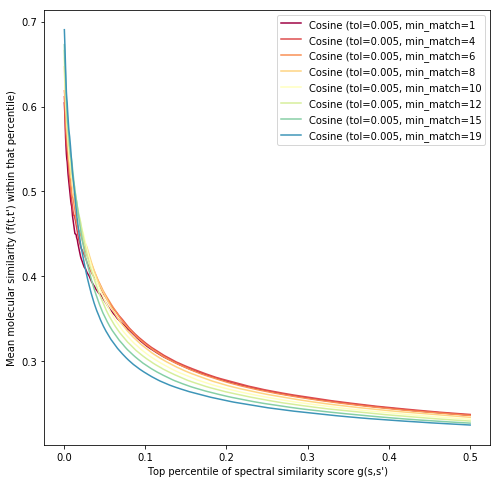

In [65]:
import matplotlib

# Compare all:
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('Spectral')

selection = [0,3,5,7,9,11,14,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection_cosine[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="Cosine (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Cosine_min_match_comparison_morgan3_dice.pdf')

In [66]:
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_1.npy', ref_score_cum_collection_cosine[0])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_6.npy', ref_score_cum_collection_cosine[5])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_8.npy', ref_score_cum_collection_cosine[7])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_10.npy', ref_score_cum_collection_cosine[9])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_14.npy', ref_score_cum_collection_cosine[13])

## Modified cosine: explore different  min_match settings

In [51]:
num_bins = 1000
show_top_percentile = 0.5

ref_score_cum_collection = []

length = mol_sim_morgan3.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])
#scores_ref = np.delete(mol_sim.reshape(length**2), remove_diagonal)

N = 19
for i in range(N):
    print("Set min_match to", i, "(round", i, "of", N, ")")
    
    # Select only those scores with > min_match matches:
    M_sim_modcos = modcos_sim_greedy * (modcos_matches_greedy > i)
    M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    scores = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    scores_sort = np.sort(scores)
    starting_point = scores_sort[int(scores.shape[0] - scores.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_scores = np.where(scores < starting_point)[0]
    scores_select = np.delete(scores, low_scores)
    scores_ref_select = np.delete(scores_ref, low_scores)

    length_selected = scores_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = scores_select
    Data[1,:] = scores_ref_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection.append(np.array(ref_score_cum))

Set min_match to 0 (round 0 of 19 )
Set min_match to 1 (round 1 of 19 )
Set min_match to 2 (round 2 of 19 )
Set min_match to 3 (round 3 of 19 )
Set min_match to 4 (round 4 of 19 )
Set min_match to 5 (round 5 of 19 )
Set min_match to 6 (round 6 of 19 )
Set min_match to 7 (round 7 of 19 )
Set min_match to 8 (round 8 of 19 )
Set min_match to 9 (round 9 of 19 )
Set min_match to 10 (round 10 of 19 )
Set min_match to 11 (round 11 of 19 )
Set min_match to 12 (round 12 of 19 )
Set min_match to 13 (round 13 of 19 )
Set min_match to 14 (round 14 of 19 )
Set min_match to 15 (round 15 of 19 )
Set min_match to 16 (round 16 of 19 )
Set min_match to 17 (round 17 of 19 )
Set min_match to 18 (round 18 of 19 )


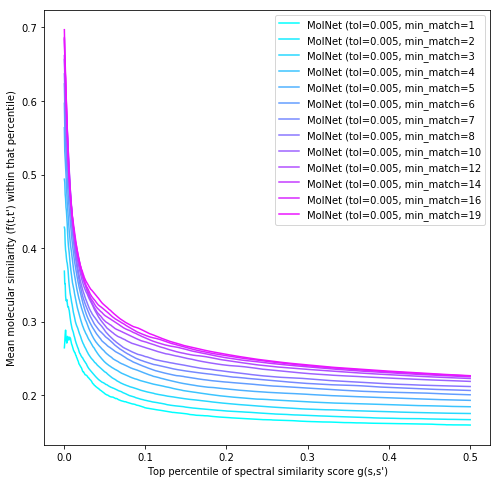

In [52]:
import matplotlib

# Compare all:
fig, ax = plt.subplots(figsize=(8,8))
#plot_colors = ['darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick', 'darkcyan', 'purple', 'seagreen', 'steelblue', 'darkcyan', 'firebrick']
#color_sequence = ['#003f5c','#882556', '#D65113', '#ffa600', '#58508d', '#bc5090', '#2651d1', '#2f4b7c', '#ff6361', '#a05195', '#d45087']
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Modcosine_min_match_comparison_morgan3_dice.pdf')

In [54]:
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_6.npy', ref_score_cum_collection[5])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_8.npy', ref_score_cum_collection[7])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_10.npy', ref_score_cum_collection[9])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_14.npy', ref_score_cum_collection[13])
np.save('Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_16.npy', ref_score_cum_collection[15])

## CAREFUL!
It looks like modified cosine score results are not only heavily depending on min_macth choices (see figure above), but also on the intitial filtering of the spectra. 

--> Needs to be compares to basic filtering (say only keep peaks > 1% max_intensity)!

---
# Compare to scores with lower tolerance 
[GNPS suggests](https://ccms-ucsd.github.io/GNPSDocumentation/networking/) either $\pm 0.5 Da$ for low resolution MS, or $\pm 0.02 Da$ for high resolution MS.

## Calculate cosine scores for all-vs all spectra

The cosine score here has two key parameters: tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the cosine score by matching peaks of two spectra. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol002.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.02,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol05.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.5,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])

## Calculate modified cosine scores for all-vs all spectra

Modified cosine score is -among others- used by [GNPS](https://ccms-ucsd.github.io/GNPSDocumentation/massspecbackground/networkingtheory/). It's key parameters are tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the modified cosine score. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol002.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.02,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol05.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.5,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])

# Alternative scenario: different filtering of spectra

In [55]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_minperc1_191110.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 1.0,
                                                           exp_intensity_filter = None,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [56]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


### Inspect data

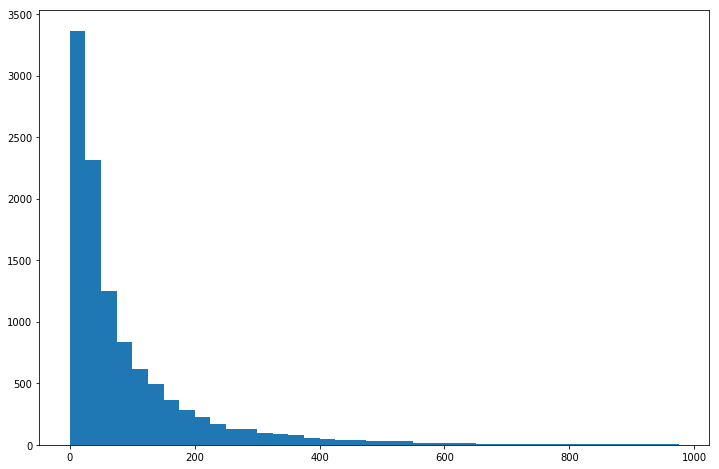

In [57]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,1000,25))

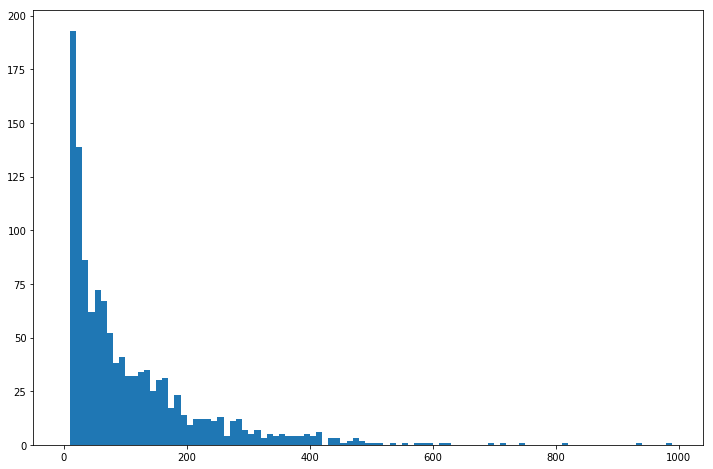

In [58]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1000,10))

---
# Calculate cosine scores for all-vs all spectra

In [7]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_minperc1_cosine_200217_tol0005.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


---
# Calculate modified cosine scores for all-vs all spectra

In [26]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_minperc1_modcos_200217_tol0005.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.
